# Journal of Finance cleaning

In [1]:
from tokenize import Ignore
from numpy import NaN
import numpy as np
import pandas as pd
from difflib import SequenceMatcher
import time
from os import path
import os
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import matplotlib.pyplot as plt 
import math

### Read in data

In [2]:
masters = pd.read_excel(Path("D:/docs/Masters/Data/Extra/jfinance_master.xlsx"))
pivots = pd.read_excel(Path("D:/docs/Masters/Data/Extra/jfinance_pivots.xlsx"))

pd.set_option('display.max_colwidth', None)

In [3]:
saveas=Path("D:/docs/Masters/Data/Extra/jfinance_processed.xlsx")


### Initial data exploration

In [81]:
masters.columns

Index(['type', 'issue_url', 'ISSN', 'URL', 'journal', 'number', 'publisher',
       'title', 'urldate', 'volume', 'year', 'abstract', 'author', 'pages',
       'reviewed-author', 'content_type'],
      dtype='object')

In [4]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp)

,title
front matter,336
back matter,322
miscellanea,144
volume information,72
books received,41
announcements,30
american finance association business proceedings,11
report of the executive secretary and treasurer,10
additions to the 1959 membership directory,10
minutes of the annual membership meeting,6


In [5]:
temp2=masters[(masters['author'].isna()==True)]['title'].str.lower().value_counts()
pd.DataFrame(temp2)

,title
front matter,336
back matter,322
miscellanea,144
volume information,72
books received,41
announcements,30
american finance association business proceedings,11
additions to the 1959 membership directory,10
activities of student affiliates,5
"business proceedings, american finance association",4


### Initial classification

From above, anything with greater than or equal to 5 duplicates are miscellaneous content. This can be classified in bulk.

Similarly, any article with a non-empty review-author field is easily classified as a review. This is because of the bibtex formatting.

In [6]:
#Remove the bulk of the miscellaneous content 
removal=list(temp[temp>=5].index)
masters.loc[masters.title.str.lower().isin(removal),'content_type']='MISC'

#Set the reviews, reviewed-author will not be null for reviewed works
masters.loc[(masters['reviewed-author'].isna()==False), 'content_type']='Review'

Classifying individual cases because these are highly likely to be miscellaneous but also have authors so we cannot blanket classify anything that does have an author as an article. Errata/erratum articles are also classified separately here.

In [7]:
masters.loc[masters['title'].str.lower().str.match(r'^editor(\'s*|ial*)')==True, 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('\[photograph\]')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('\[obituary\]')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('\[announcement.*\]')==True, 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('american finance association')==True, 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('errata')==True, 'content_type']='Errata'
masters.loc[masters['title'].str.lower().str.contains('erratum')==True, 'content_type']='Errata'
masters.loc[masters['title'].str.lower().str.contains(r'^report of the')==True, 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains('minutes of ')==True, 'content_type']='MISC'
masters.loc[(masters['content_type'].isna()==True)&(masters['author'].isna()==True), 'content_type']="MISC"

### Discussions

In [8]:
masters.loc[(masters['title'].str.lower().str.contains('discussion')==True), 'content_type']='Discussions'

### Replies

In [9]:
masters.loc[(masters['title'].str.lower().str.match(r'.*a reply')==True),'content_type']='Reply'


### Comment

In [10]:
masters.loc[(masters['title'].str.lower().str.match(r'.*comment(|s)')==True),'content_type']='Comment'

### Articles

In [11]:
masters.loc[(masters['content_type'].isna()==True),'content_type']='Article'

### Saving ...

In [94]:
masters.to_excel(saveas, index=False)

## Exploratory statistics
### Summary

In [12]:
masters.content_type.value_counts()

Article        5586
Review         2028
MISC           1247
Discussions     378
Comment         215
Reply            38
Errata           20
Name: content_type, dtype: int64

### Author counts

In [13]:
check_data=pd.DataFrame()
for i in masters.index:
    if ((masters.iloc[i]['content_type']!='MISC') & (masters.iloc[i]['content_type']!='Review')& ( pd.isnull(masters.iloc[i]['author'])!=True)):
    #if ((masters.iloc[i]['content_type']=='Article')& ( pd.isnull(masters.iloc[i]['author'])!=True)):
        authors=[]
        presplit=masters.iloc[i]['author'].split(' and ')
        for a in presplit:
            if a.__contains__('Jr.') or a.__contains__('Jr'):
                #print('found junior')
                #print(a)
                
                authors=np.concatenate((authors,[a.replace(', Jr.',' Jr.')]))
            else:
                authors=np.concatenate((authors,a.split(', ')))
        #print('_'.join(list(authors))+" "+str(len(authors)) + str(Merged.iloc[i]['year']))
        
        check_data=pd.concat([check_data, pd.DataFrame([{'pdf_url': masters.iloc[i]['URL'],'authors':'\''+'_'.join(list(authors))+'\'', 'num_auth':len(authors),'year':masters.iloc[i]['year']}])], ignore_index=True)
        

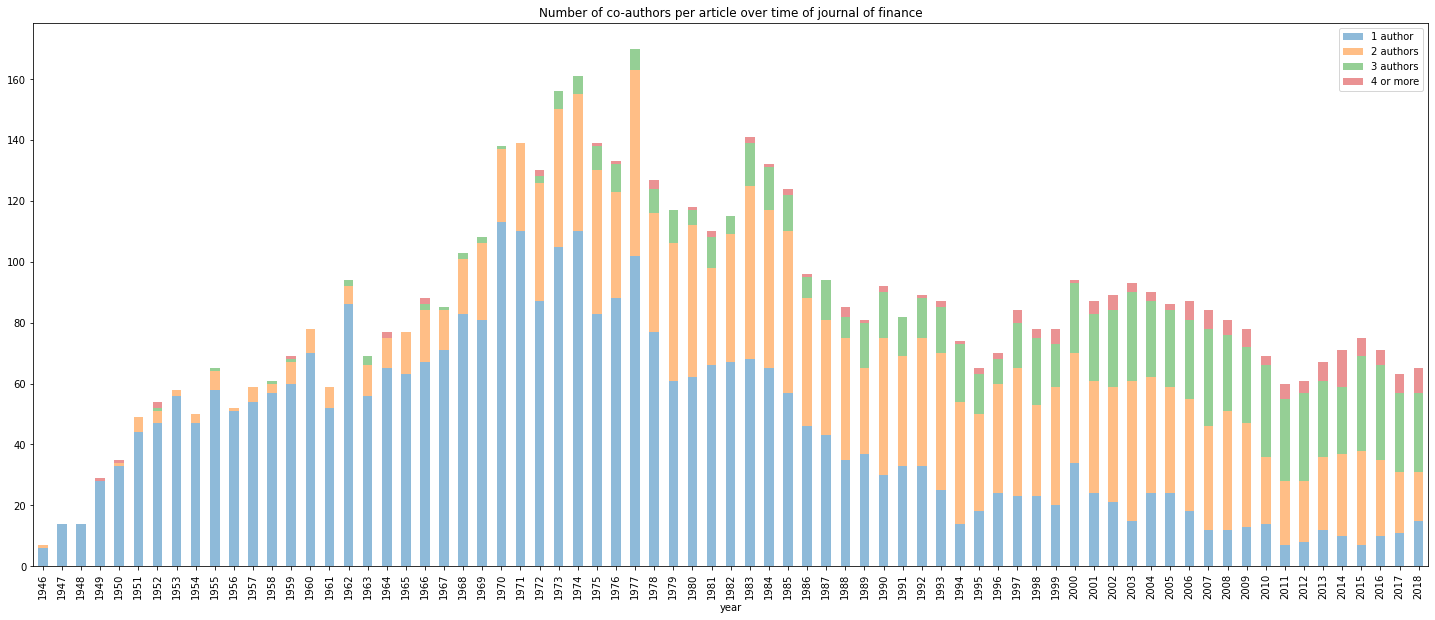

In [15]:
plt.rcParams["figure.figsize"] = (25, 10)
tmp=pd.DataFrame()
tmp['1 author']=check_data[check_data['num_auth']==1]['year'].value_counts()
tmp['2 authors']=check_data[check_data['num_auth']==2]['year'].value_counts()
tmp['3 authors']=check_data[check_data['num_auth']==3]['year'].value_counts()
tmp['4 or more']=check_data[check_data['num_auth']>3]['year'].value_counts()

tmp=tmp.reset_index()
tmp=tmp.sort_values(by='index')

ax=tmp.plot.bar(x='index', stacked=True, title='Number of co-authors per article over time of journal of finance',alpha=0.5, legend=True, xlabel='year')


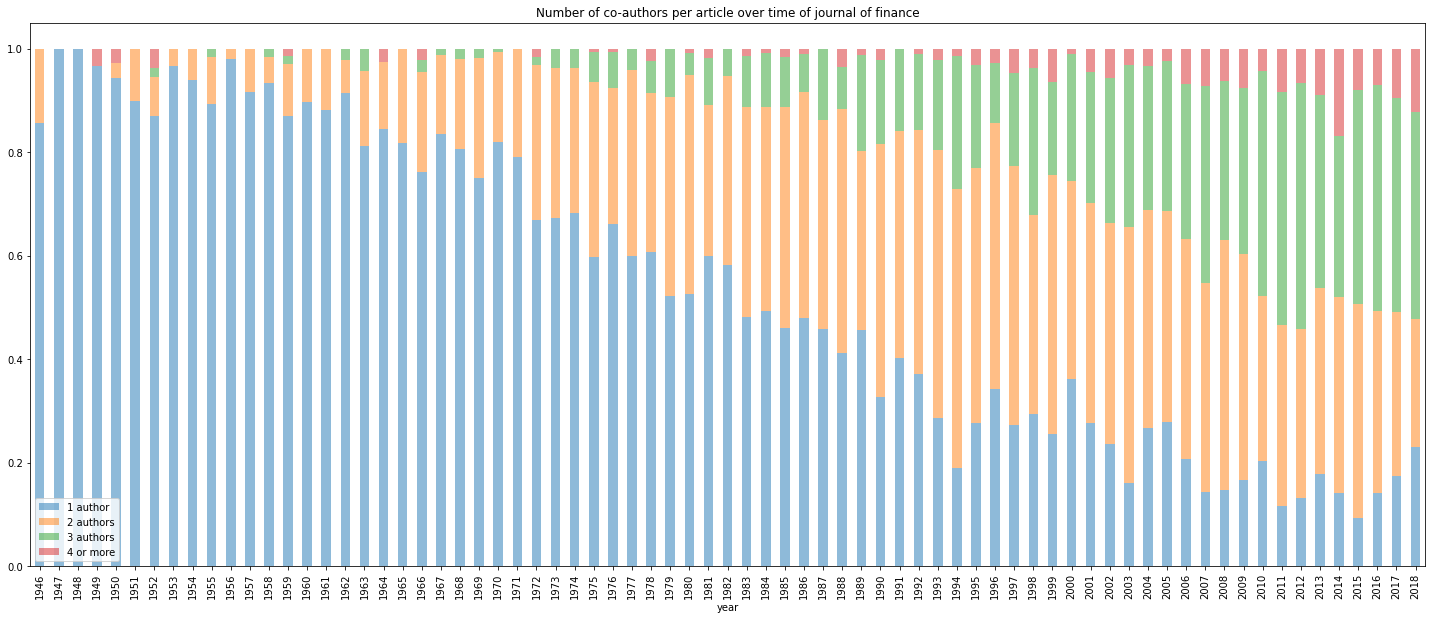

In [118]:
plt.rcParams["figure.figsize"] = (25, 10)
tmp=pd.DataFrame()
norm=check_data['year'].value_counts()
tmp['1 author']=check_data[check_data['num_auth']==1]['year'].value_counts()/norm
tmp['2 authors']=check_data[check_data['num_auth']==2]['year'].value_counts()/norm
tmp['3 authors']=check_data[check_data['num_auth']==3]['year'].value_counts()/norm
tmp['4 or more']=check_data[check_data['num_auth']>3]['year'].value_counts()/norm

tmp=tmp.reset_index()
tmp=tmp.sort_values(by='index')

ax=tmp.plot.bar(x='index', stacked=True, title='Number of co-authors per article over time of journal of finance',alpha=0.5, legend=True, xlabel='year')


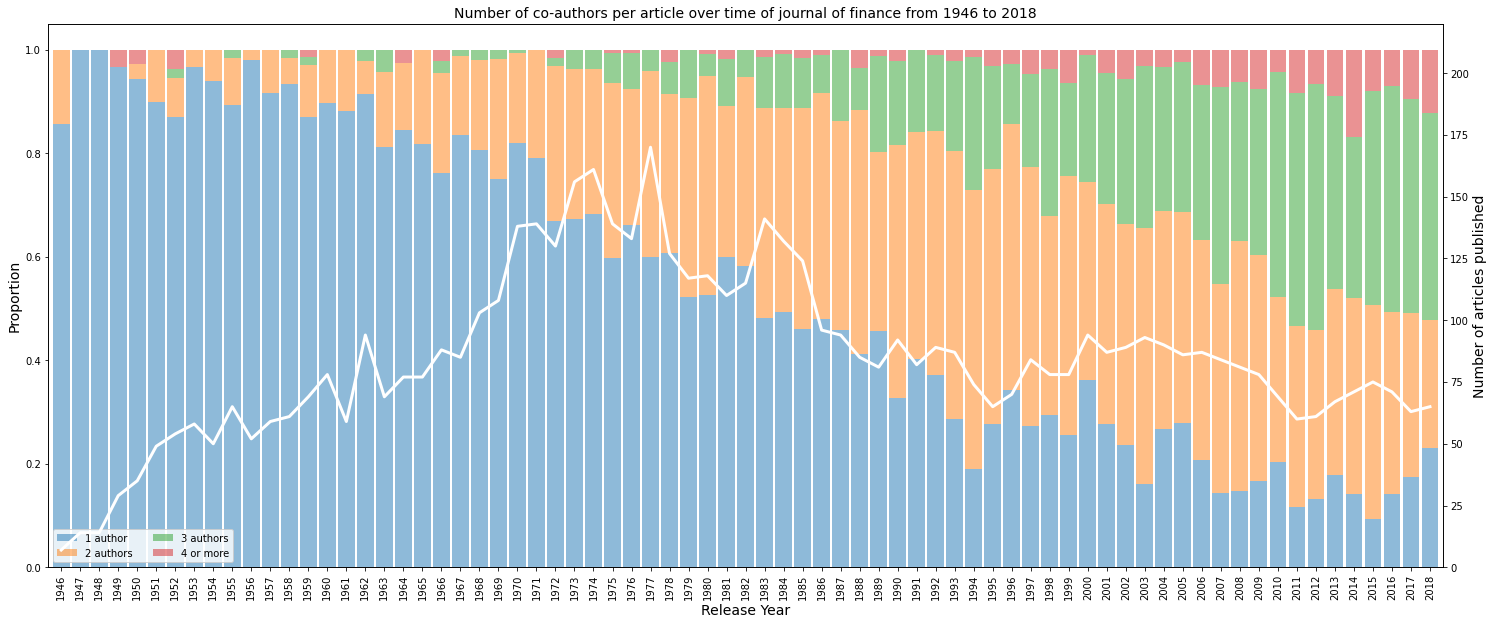

In [21]:

tmp2=pd.DataFrame()

total=check_data['year'].value_counts()
tmp2['1 author']=check_data[check_data['num_auth']==1]['year'].value_counts()/total
tmp2['2 authors']=check_data[check_data['num_auth']==2]['year'].value_counts()/total
tmp2['3 authors']=check_data[check_data['num_auth']==3]['year'].value_counts()/total
tmp2['4 or more']=check_data[check_data['num_auth']>3]['year'].value_counts()/total


tmp2=tmp2.reset_index()
tmp2=tmp2.sort_values(by='index')
ax1=tmp2.plot.bar(x='index', 
                  stacked=True, 
                  alpha=0.5, 
                  legend=True, 
                  xlabel='year', 
                  width=0.88
                 )
#ax1.set_facecolor('black')
plt.legend(loc="lower left", ncol=2)
plt.xlabel("Release Year", size=14)
plt.ylabel("Proportion", size=14)
plt.title('Number of co-authors per article over time of journal of finance from 1946 to 2018', size=14)
ax2=ax1.twinx()
total.sort_index().plot(use_index=False, ax=ax2, color='white', linewidth=3)
#ax2.get_legend().remove()
ax2.set_ylabel("Number of articles published", size=14)

ax1.plot( use_index=False, ax=ax1, color='red', linewidth=1)  
#plt.grid(True)
ax2.set_ylim(0,220)
plt.show()